# Overview of Image-Based Two-Phase Flow Simulations - Part 3: Injection

In parts 1 and 2 of this series we looked at `drainage` and `imbibition`, which are both pressure-controlled displacement processes.  This refers to the fact that a fixed pressure is applied to the invading phase, and all the accessible pore space become filled. In the present tutorial we will look at the `injection` algorithm, which simulates volume-controlled invasion of non-wetting fluid. In this process the invasion front moves incrementally as though being injected by positive displacement pump, like as syringe pump. 

The objectives of this tutorial are as follows:

- Give an overview of the various ways to use the `porespy.simulations.injection` algorithm
- Demonstrate how the definition of inlets and outlets affects the result
- Explain the conventions used for dealing with trapped wetting phase in displacement maps
- Plot capillary pressure curves using the results of an invasion simulation, and compare it to a drainage simulation.

## Setup

As usual, we start by importing the necessary packages, and creating a test image which will be used throughout.  The test image is 2D for visualization purposes, but everything discussed here applies to 3D as well.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

import porespy as ps

ps.visualization.set_mpl_style()

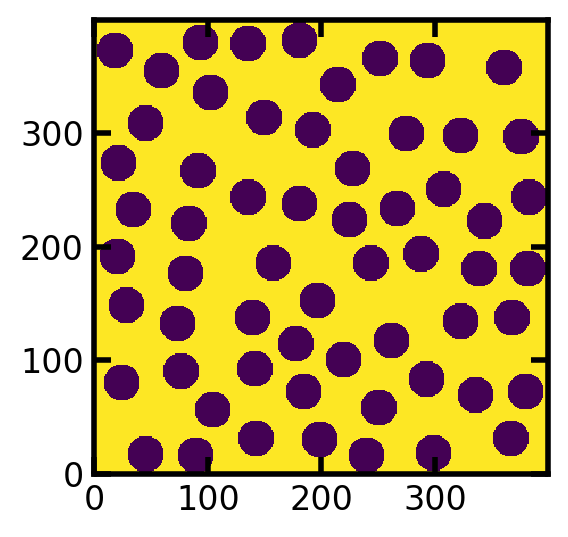

In [5]:
im = ~ps.generators.random_spheres([400, 400], r=15, clearance=10, seed=22)
fig, ax = plt.subplots(figsize=[3, 3])
ax.imshow(im);


### Define Inlets, Capillary Transform, and Run A Simulation

The inlets specified as a Numpy array the same shape as `im` with `True` values indicating inlet locations and `False` elsewhere. The capillary pressure transform can found using the `capillary_transform` function.  


In [6]:
inlets = ps.generators.faces(im.shape, inlet=0)
pc = ps.filters.capillary_transform(
    im=im,
    sigma=0.01,
    theta=180,
    voxel_size=1e-4,
)
inv1 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    return_pressures=True,
)

### Inspect Displacement Maps

The `injection` function returns a `Results` object which is a dataclass-like object with various images attached as attributes.  The main images are the sequence map, the saturation map, and the capillary pressure map.  These are shown below:

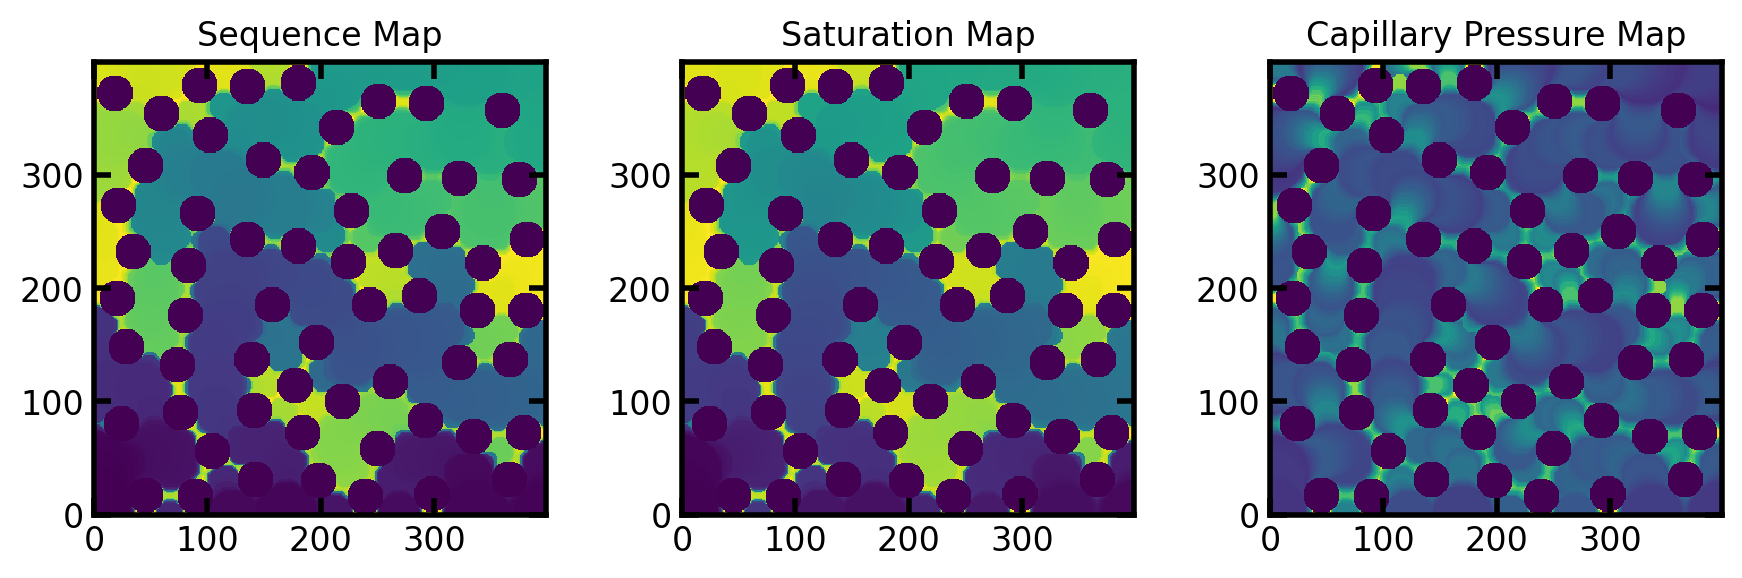

In [7]:
fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(inv1.im_seq)
ax[1].imshow(inv1.im_snwp)
ax[2].imshow(inv1.im_pc, vmax=inv1.im_pc.max()/5)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

### Obtaining Specific Fluid Configurations

Either the sequence map or the saturation map can be used to find specific fluid configurations. The saturation map is particularly useful since the saturation are *almost* continuous, unlike the pressure-based simulations where large jumps in saturations are ever-present.  The saturation is not *actually* continuous so technically we should still only values present the saturation map as the threshold values, but for all practical purposes we can do the following:

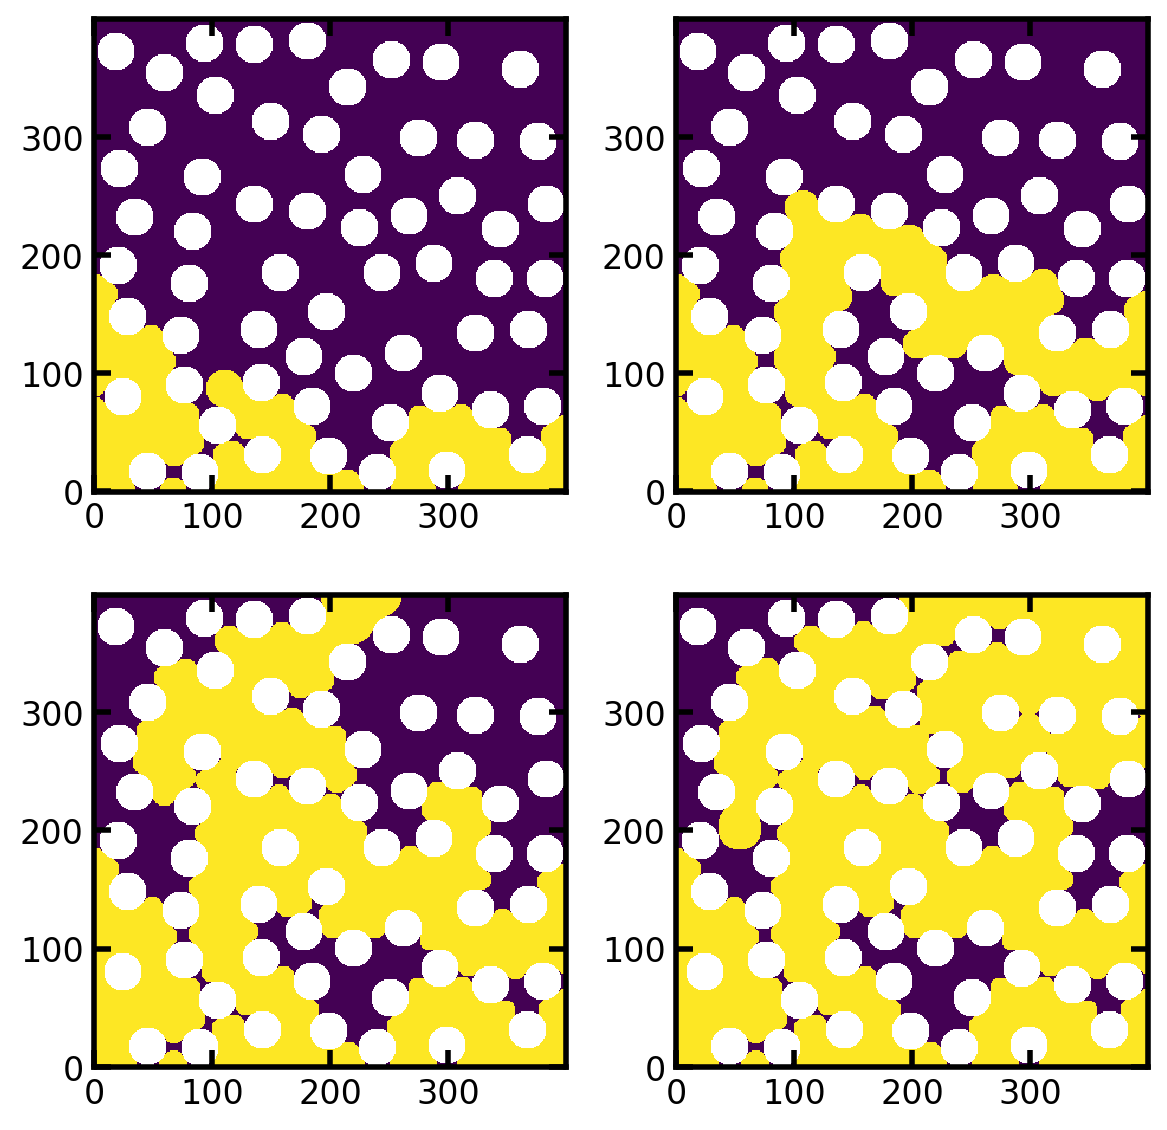

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(6, 6))
ax[0][0].imshow((inv1.im_snwp <= 0.2)/im)
ax[0][1].imshow((inv1.im_snwp <= 0.4)/im)
ax[1][0].imshow((inv1.im_snwp <= 0.6)/im)
ax[1][1].imshow((inv1.im_snwp <= 0.8)/im);


And to confirm that we achieved fairly close to the requested saturation, we can compute the saturation of each resulting configuraiton:

In [9]:
for s in [0.2, 0.4, 0.6, 0.8]:
    satn = (inv1.im_snwp <= s)[im].sum()/im.sum()
    print(f"Requested: {s}, Actual {satn}")


Requested: 0.2, Actual 0.19967977228251202
Requested: 0.4, Actual 0.39999110478562533
Requested: 0.6, Actual 0.5999644191425013
Requested: 0.8, Actual 0.7995018679950187


On a 3D image this difference will be even less since there are many more voxels so the saturation increments will be even smaller.

### Generating Capillary Pressure Curves from Displacement Maps

Capillary pressures curves produced by a volume-controlled invasion process are not very common, and they are difficult to interpret. They are also more difficult to extract from displacement maps.  The non-wetting phase saturation (i.e. the y-axis) is easily obtained by summing the number of voxels invaded at or below each value in the sequence map.  Finding the correspond capillary pressure is the challenging part because it does not increase monotonically, but rather fluctuates up and down as fluid invades smaller and larger regions (i.e. throat constrictions and pore bodies).  This means that one cannot simply apply a threshold to the capillary pressure map, but instead we must use the sequence map to find the voxels filled at each step, then use that as a mask into the capillary pressure map to determine the capillary pressure. This is illustrated below:

In [10]:
Pc, Snwp = [], []
steps = np.unique(inv1.im_seq[im])
for s in steps:
    mask = inv1.im_seq == s
    Snwp.append(mask.sum())
    Pc.append(inv1.im_pc[mask][0])
Pc = np.array(Pc)
Snwp = np.cumsum(Snwp)/im.sum()


Of course PoreSpy offers the `pc_map_to_pc_curve` function which works on the displacement maps produced by the `injection` simulation, provided that the sequence map is also provided.  Note that the invasion is technically a drainage process since non-wetting phase is displacing the wetting phase, so `mode='drainage'` should be specified. 

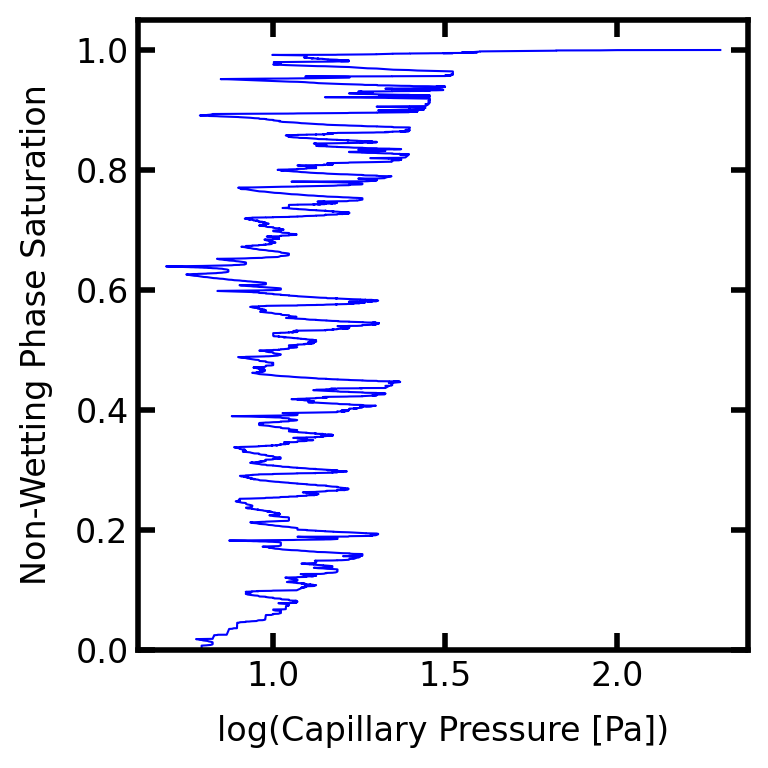

In [11]:
Pc1, Snwp1 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=inv1.im_pc,
    seq=inv1.im_seq,
    mode='drainage',
)

fig, ax = plt.subplots(figsize=[4, 4])
ax.plot(np.log10(Pc1), Snwp1, linewidth=0.75, color='blue', label='injection')
ax.set_xlabel('log(Capillary Pressure [Pa])')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_ylim([0, 1.05]);

### Comparison of Injection and Drainage

The above plot shows the fluctuating capillary pressure due the non-wetting fluid squeezing through throat constrictions then flooding into pore bodies repeatedly.  In fact the *envelop* of peak pressures in the above curve defines the capillary pressure curve that would be obtained using pressure-based drainage.  This can be illustrated by overlaying the drainage curve:

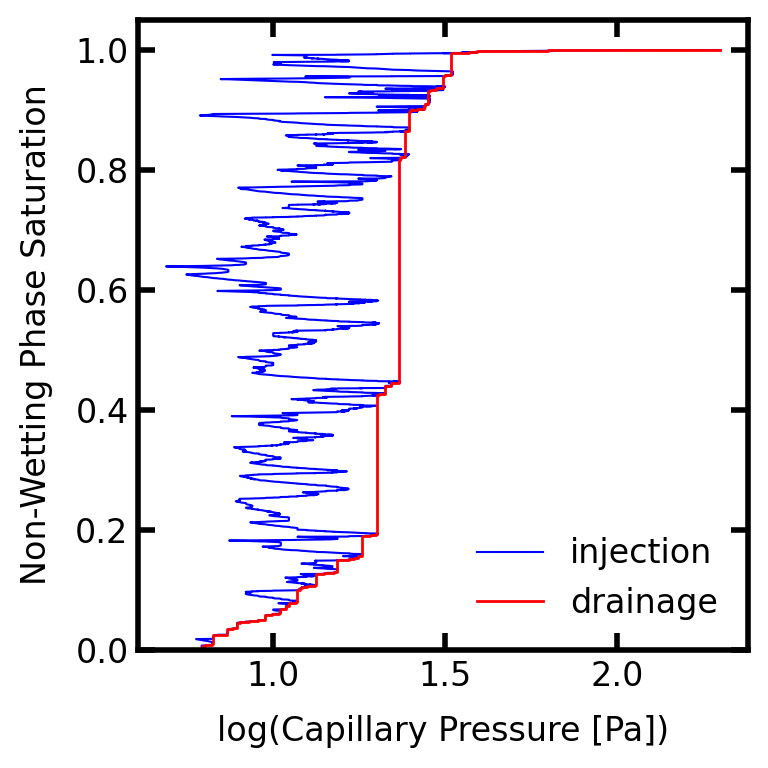

In [12]:
drn = ps.simulations.drainage(
    im=im,
    pc=pc,
    inlets=inlets,
    steps=None,
)

Pc2, Snwp2 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=drn.im_pc,
    mode='drainage',
)

ax.step(np.log10(Pc2), Snwp2, linewidth=1.0, color='red', label='drainage')
ax.legend()
display(fig);

When plotted together it becomes apparent that the drainage curve is a subset of the injection curve, and that the pressure fluctuations in the invasion curve represent the filling of the voids made accessible at each new peak pressure.

### Incorporating Trapping in Injection

As with the drainage and imbibition algorithms discussed in Parts 1 and 2 of this series, the effect of trapped wetting phase can be incorporated by supplying a mask of `outlets`.  This will automatically apply trapping to the displacement maps.

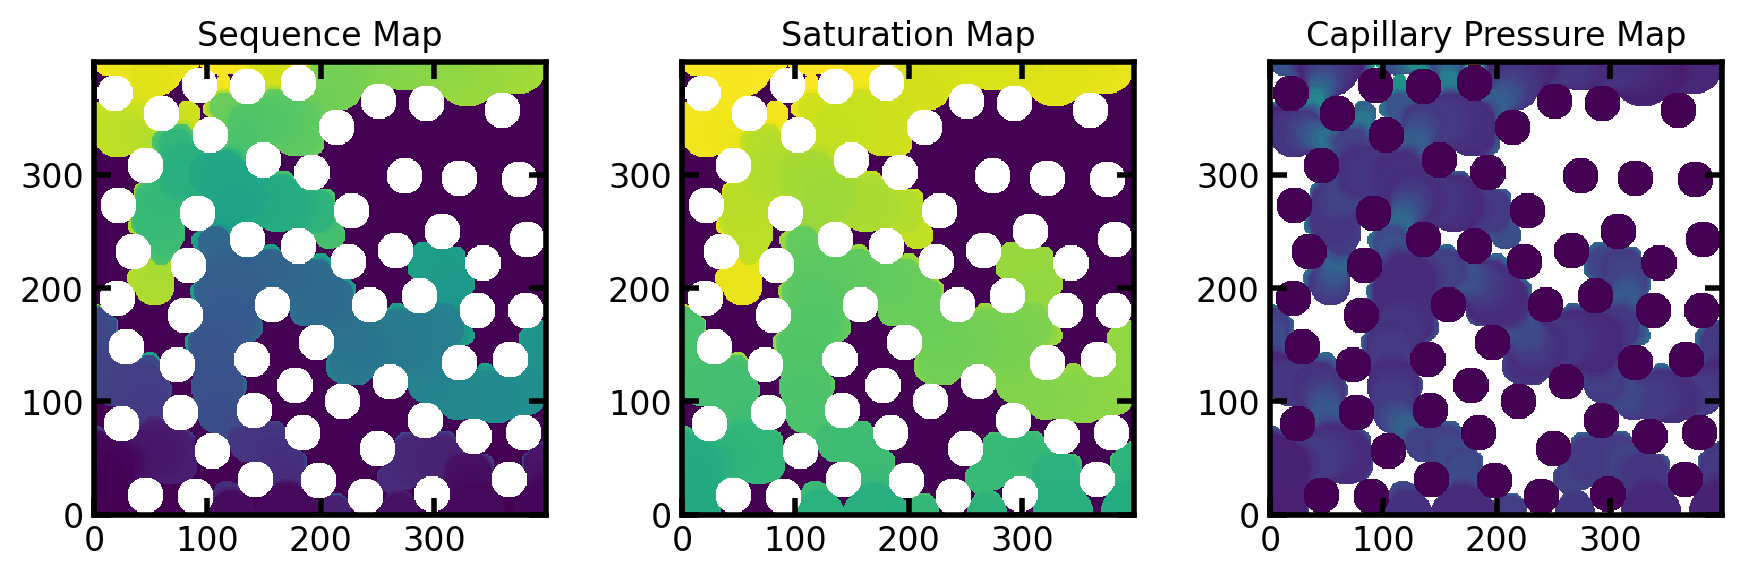

In [13]:
outlets = ps.generators.faces(im.shape, outlet=0)
inv2 = ps.simulations.injection(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    return_pressures=True,
    min_size=3,
)

fig, ax = plt.subplots(1, 3, figsize=[9, 3])
ax[0].imshow(inv2.im_seq/im)
ax[1].imshow(inv2.im_snwp/im)
ax[2].imshow(inv2.im_pc)
ax[0].set_title("Sequence Map")
ax[1].set_title("Saturation Map")
ax[2].set_title("Capillary Pressure Map");

Trapped wetting phase is marked with a `-1` in both the sequence and the saturation maps, and and `+inf` in the capillary pressure map.

### Plotting Capillary Pressure Curves with Trapping

The non-wetting phase saturation does not reach `1.0` when trapping occurs.  Interestingly, quite a lot more trapping occurs when in an `invasion` simulation that during an otherwise equivalent `drainage` simulation.  This is because `invasion` captures all of the individual menisci movements that occur and hence there are more opportunities for trapping.

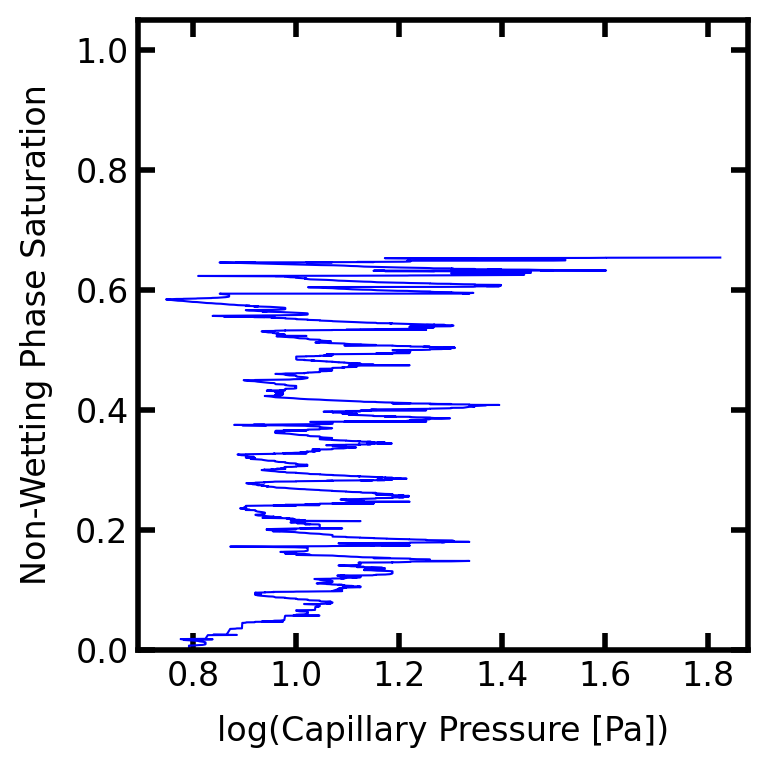

In [14]:
Pc3, Snwp3 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=inv2.im_pc,
    seq=inv2.im_seq,
    mode='drainage',
)

fig, ax = plt.subplots(figsize=[4, 4])
ax.plot(np.log10(Pc3), Snwp3, linewidth=0.75, color='blue', label='injection')
ax.set_xlabel('log(Capillary Pressure [Pa])')
ax.set_ylabel('Non-Wetting Phase Saturation')
ax.set_ylim([0, 1.05]);

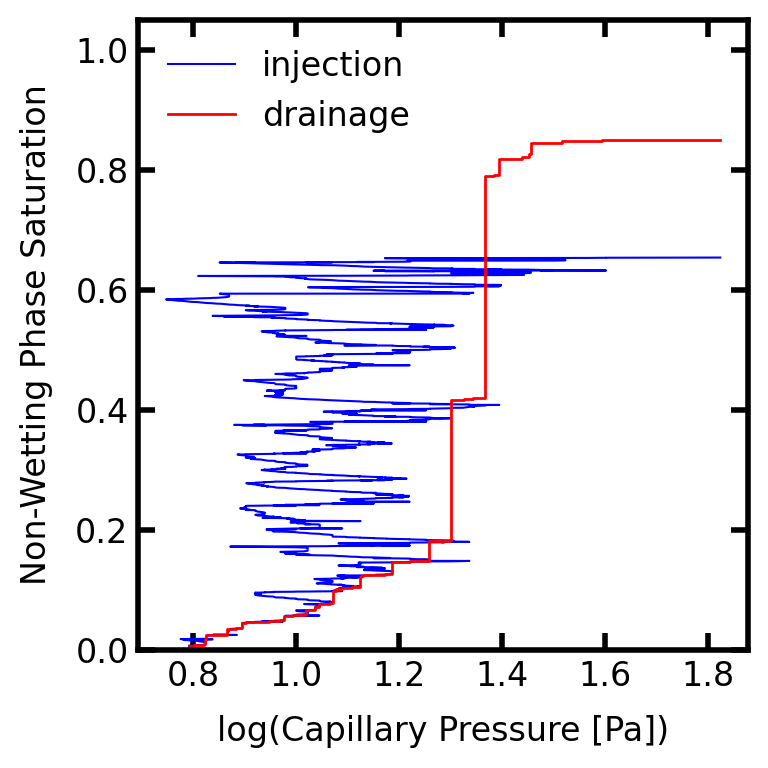

In [15]:
drn2 = ps.simulations.drainage(
    im=im,
    pc=pc,
    inlets=inlets,
    outlets=outlets,
    steps=None,
)

Pc4, Snwp4 = ps.metrics.pc_map_to_pc_curve(
    im=im,
    pc=drn2.im_pc,
    mode='drainage',
)

ax.step(np.log10(Pc4), Snwp4, linewidth=1.0, color='red', label='drainage')
ax.legend()
display(fig);

## Summary

The `injection` function simulates volume-controlled injection of non-wetting phase into an image. In can incorporate trapping but does net yet support inclusion of residual non-wetting phase (though this is possible and is planned). 

The following table illustrates how the trapped phase is indicated in the various displacement maps:

+-------------------+--------------+-----------------+------------------------------------+
| Displacement Map  | Trapped NWP  | Residual WP     | Code to Generate Swp               |
+-------------------+--------------+-----------------+------------------------------------+
| Pc Map            | $-inf$       | N/A             | `(im_pc > p) * im`                 |
+-------------------+--------------+-----------------+------------------------------------+
| Sequence Map      | -1           | N/A             | `(im_seq < N) * (im_seq >= 0)`     |
+-------------------+--------------+-----------------+------------------------------------+
| Saturation Map    | -1           | N/A             | `(im_snwp > s)`                    |
+-------------------+--------------+-----------------+------------------------------------+